<a href="https://colab.research.google.com/github/soumick1/Tabular-data-extraction-from-images-OCR-/blob/main/Image_Prepro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
from google.colab.patches import cv2_imshow

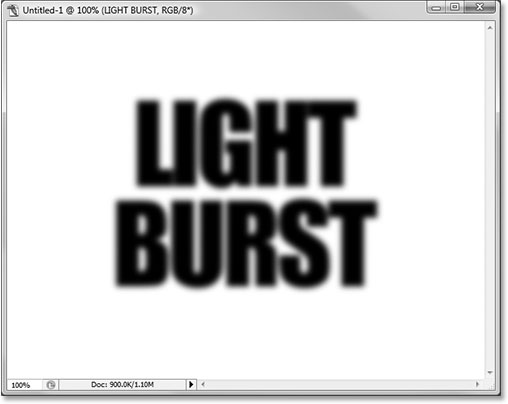

In [ ]:
file = r'/content/blurred-text.jpg'

im = cv2.imread(file,0)
cv2_imshow(im)

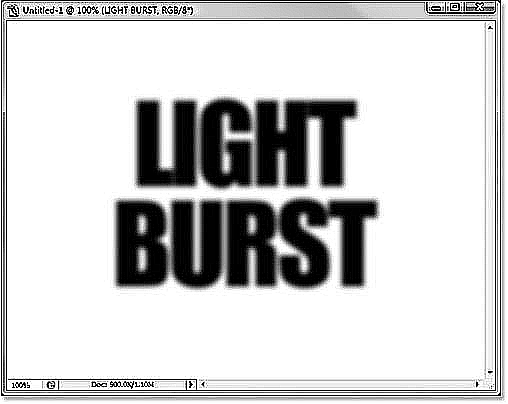

In [ ]:
file = r'/content/blurred-text.jpg'

im = cv2.imread(file,0)

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(im, -1, kernel)
cv2_imshow(im)

In [ ]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [ ]:
def example():
    image = cv2.imread('/content/blurred-text.jpg')
    sharpened_image = unsharp_mask(image)
    cv2.imwrite('my-sharpened-image.jpg', sharpened_image)
    cv2_imshow(sharpened_image)

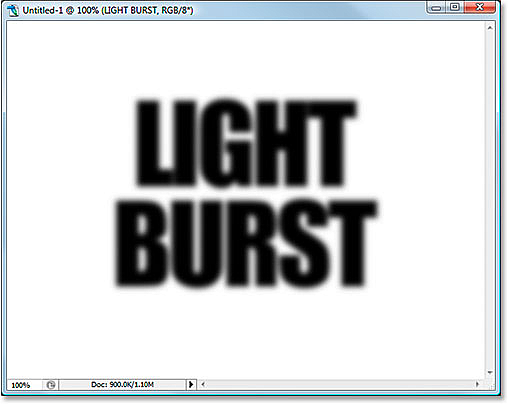

In [ ]:
example()

In [ ]:
import os
import cv2
import imutils

# Important parameters:
#  - morph_size
#  - min_text_height_limit
#  - max_text_height_limit
#  - cell_threshold
#  - min_columns



def pre_process_image(img, save_in_file, morph_size=(8, 8)):

    # get rid of the color
    pre = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Otsu threshold
    pre = cv2.threshold(pre, 250, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, morph_size)
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy

    if save_in_file is not None:
        cv2.imwrite(save_in_file, pre)
    return pre


def find_text_boxes(pre, min_text_height_limit=6, max_text_height_limit=40):
    # Looking for the text spots contours
    # OpenCV 3
    # img, contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # OpenCV 4
    contours, hierarchy = cv2.findContours(pre, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Getting the texts bounding boxes based on the text size assumptions
    boxes = []
    for contour in contours:
        box = cv2.boundingRect(contour)
        h = box[3]

        if min_text_height_limit < h < max_text_height_limit:
            boxes.append(box)

    return boxes


def find_table_in_boxes(boxes, cell_threshold=10, min_columns=2):
    rows = {}
    cols = {}

    # Clustering the bounding boxes by their positions
    for box in boxes:
        (x, y, w, h) = box
        col_key = x // cell_threshold
        row_key = y // cell_threshold
        cols[row_key] = [box] if col_key not in cols else cols[col_key] + [box]
        rows[row_key] = [box] if row_key not in rows else rows[row_key] + [box]

    # Filtering out the clusters having less than 2 cols
    table_cells = list(filter(lambda r: len(r) >= min_columns, rows.values()))
    # Sorting the row cells by x coord
    table_cells = [list(sorted(tb)) for tb in table_cells]
    # Sorting rows by the y coord
    table_cells = list(sorted(table_cells, key=lambda r: r[0][1]))

    return table_cells


def build_lines(table_cells):
    if table_cells is None or len(table_cells) <= 0:
        return [], []

    max_last_col_width_row = max(table_cells, key=lambda b: b[-1][2])
    max_x = max_last_col_width_row[-1][0] + max_last_col_width_row[-1][2]

    max_last_row_height_box = max(table_cells[-1], key=lambda b: b[3])
    max_y = max_last_row_height_box[1] + max_last_row_height_box[3]

    hor_lines = []
    ver_lines = []

    for box in table_cells:
        x = box[0][0]
        y = box[0][1]
        hor_lines.append((x, y, max_x, y))

    for box in table_cells[0]:
        x = box[0]
        y = box[1]
        ver_lines.append((x, y, x, max_y))

    (x, y, w, h) = table_cells[0][-1]
    ver_lines.append((max_x, y, max_x, max_y))
    (x, y, w, h) = table_cells[0][0]
    hor_lines.append((x, max_y, max_x, max_y))

    return hor_lines, ver_lines




In [ ]:
if __name__ == "__main__":

    in_file = '/content/DataTable01.png'
    pre_file = '/content/pre.png'
    out_file = '/content/out.png'

    img = cv2.imread(in_file)

    pre_processed = pre_process_image(img, pre_file)
    text_boxes = find_text_boxes(pre_processed)
    cells = find_table_in_boxes(text_boxes)
    hor_lines, ver_lines = build_lines(cells)

    # Visualize the result
    vis = img.copy()

    # for box in text_boxes:
    #     (x, y, w, h) = box
    #     cv2.rectangle(vis, (x, y), (x + w - 2, y + h - 2), (0, 255, 0), 1)

    for line in hor_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    for line in ver_lines:
        [x1, y1, x2, y2] = line
        cv2.line(vis, (x1, y1), (x2, y2), (0, 0, 255), 1)

    cv2.imwrite(out_file, vis)

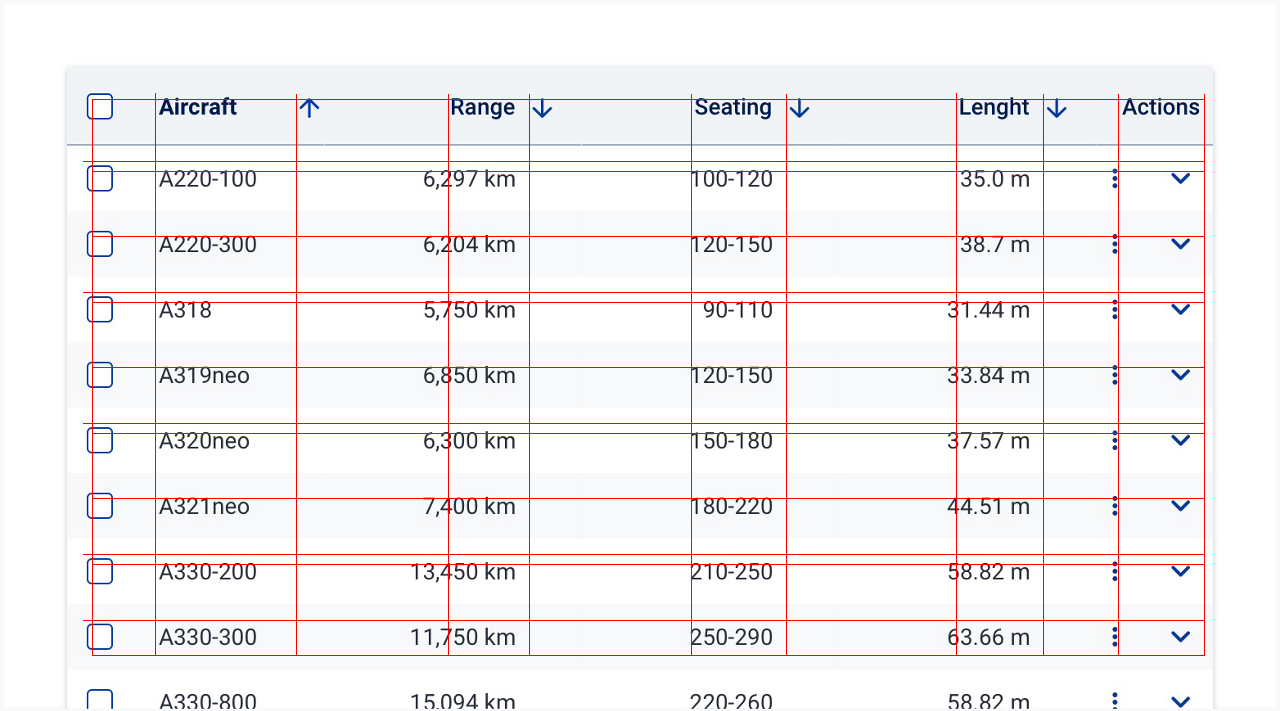

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(cv2.imread('/content/out.png'))